In [ ]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# openPMD beamphysics examples

In [2]:
from pmd_beamphysics import ParticleGroup,  particle_paths
from pmd_beamphysics.readers import all_components, component_str

from h5py import File
import numpy as np
import os

In [3]:
# Open a file, fine the particle paths from the root attributes
# Pick one:
#H5FILE = 'data/bmad_particles.h5'
H5FILE = 'data/distgen_particles.h5'
#H5FILE = 'data/astra_particles.h5'
h5 = File(H5FILE, 'r')


ppaths = particle_paths(h5)
ppaths

['/data/0/particles/']

In [4]:
# Point to particles
ph5 = h5[ppaths[0]]
list(ph5)

['momentum', 'position', 'time', 'weight']

In [5]:
# Search for all valid components
all_components(ph5)

['momentum/x',
 'momentum/y',
 'momentum/z',
 'position/x',
 'position/y',
 'position/z',
 'time',
 'weight']

In [6]:
# Get some info
for component in all_components(ph5):
    info = component_str(ph5, component)
    print(info)

momentum/x [10000 items] is a momentum with units: kg*m/s
momentum/y [10000 items] is a momentum with units: kg*m/s
momentum/z [10000 items] is a momentum with units: kg*m/s
position/x [10000 items] is a length with units: m
position/y [10000 items] is a length with units: m
position/z [10000 items] is a length with units: m
time [10000 items] is a time with units: s
weight [10000 items] is a charge with units: C, but expected units: C


# ParticleGroup class

In [7]:
# Parse all these into a class
P = ParticleGroup(ph5)

In [8]:
?P

Type:        ParticleGroup
String form: ParticleGroup with 10000 particles with total charge 2.3e-09 C
File:        ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/particles.py
Docstring:  
Particle Group class

Initialized on on openPMD beamphysics particle group.

The fundamental bunch data is stored in __dict__ with keys
    str: species
    int: n_particle
    np.array: x, px, y, py, z, pz, t, status, weight
where:
    x, y, z are positions in units of [m]
    px, py, pz are momenta in units of [eV/c]
    t is time in [s]
    weight is the macro-charge weight in [C], used for all statistical calulations.
    
Derived data can be computed as attributes:
    .gamma, .beta, .beta_x, .beta_y, .beta_z: relativistic factors [1].
    .energy : total energy [eV]
    .kinetic_energy: total energy - mc^2 in [eV]. 
    .p: total momentum in [eV/c]
    .mass: rest mass in [eV]
    .xp, .yp: Slopes x' = dx/dz = dpx/dpz and y' = dy/dz = fpy/dpz [1].
    
Statistics of any of these are calculat

In [9]:
# x positions, in meters
P.x

array([0.00010713, 0.00034532, 0.00024771, ..., 0.00038017, 0.00028772,
       0.00046803])

In [10]:
# relativistic gamma, calculated on the fly
P.gamma

array([1.00000219, 1.00000203, 1.00000202, ..., 1.00000221, 1.00000192,
       1.00000205])

In [11]:
# Statistics on any of these. Note that these properly use the .weight array. 
P.avg('gamma'), P.std('p')

(1.0000004403138123, 186.22483618654297)

In [12]:
# Covariance matrix of any list of keys
P.cov('x', 'px', 'y', 'kinetic_energy')

array([[ 5.53424144e-08, -2.83169899e-05, -8.85128475e-14,
         1.72426809e-05],
       [-2.83169899e-05,  7.66575008e+04, -2.98184921e-05,
        -1.86303272e-01],
       [-8.85128475e-14, -2.98184921e-05,  5.53424144e-08,
        -1.05619719e-08],
       [ 1.72426809e-05, -1.86303272e-01, -1.05619719e-08,
         3.34831086e-02]])

In [13]:
# These can all be accessed with brackets. sigma_ and mean_ are also allowed
P['sigma_x'], P['sigma_energy'], P['min_y'], P['norm_emit_x']

(0.00023523792234909837,
 0.18297475321038184,
 -0.0004981677461026075,
 1.2746364399849068e-07)

In [14]:
# Covariance has a special syntax, items separated by __
P['cov_x__kinetic_energy']

1.7242680914253996e-05

In [15]:
# Units can be retrieved from any computable quantitiy.
# These are returned as a pmd_unit type.
P.units('x'), P.units('energy'), P.units('norm_emit_x'), P.units('cov_x__kinetic_energy')

(pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0)),
 pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0)),
 pmd_unit('m*eV', 1.602176634e-19, (3, 1, -2, 0, 0, 0, 0)))

In [16]:
# 
str(P.units('cov_x__kinetic_energy'))

'm*eV'

In [17]:
# These particles are from Bmad, at the same z and different times
P.std('z'), P.std('t')

(0.0, 8.499999999999998e-12)

In [18]:
# Get the central time
t0 = P.avg('t')
t0

1.8846240950683415e-29

In [19]:
# Drift all particles to this time
P.drift_to_t(t0)

In [20]:
# Now these are at different z, and the same t
P.std('z'), P.avg('t'), set(P.t)

(1.3782686282191496e-06, 1.8846240950683418e-29, {1.8846240950683415e-29})

# Writing

In [21]:
newh5file = 'particles.h5'

with File(newh5file, 'w') as h5:
    P.write(h5)
    
with File(newh5file, 'r') as h5:
    P2 = ParticleGroup(h5)    

In [22]:
# Check if all are the same
for key in ['x', 'px', 'y', 'py', 'z', 'pz', 't', 'status', 'weight']:
    same = np.all(P[key] == P2[key])
    print(key, same)

x True
px True
y True
py True
z True
pz True
t True
status True
weight True


In [23]:
# Write Astra-style particles
P.write_astra('astra.dat')

In [24]:
!head astra.dat

  1.535211890566e-09   1.856269525000e-09   1.070586469769e-09   5.945360652725e-15  -4.585457743500e-15   2.209872469869e+02   1.884624095068e-20   0.000000000000e+00    1   -1
  1.176211316871e-04   0.000000000000e+00  -1.070586469769e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   1.401298464325e-45   0.000000000000e+00    1   -3
  0.000000000000e+00   1.176210509770e-04  -1.070586469769e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -1.401298464325e-45   0.000000000000e+00    1   -3
  2.352422633742e-04   0.000000000000e+00  -1.070586469769e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00   2.802596928650e-45   0.000000000000e+00    1   -3
  0.000000000000e+00   2.352421019540e-04  -1.070586469769e-09   0.000000000000e+00   0.000000000000e+00   0.000000000000e+00  -2.802596928650e-45   0.000000000000e+00    1   -3
  3.528633950613e-04   0.000000000000e+00  -1.070586469769e-09   0.000000000000e+00   0.000000000000e+00   0.0

# Plot

In [25]:
import matplotlib.pyplot as plt
import matplotlib
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
matplotlib.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


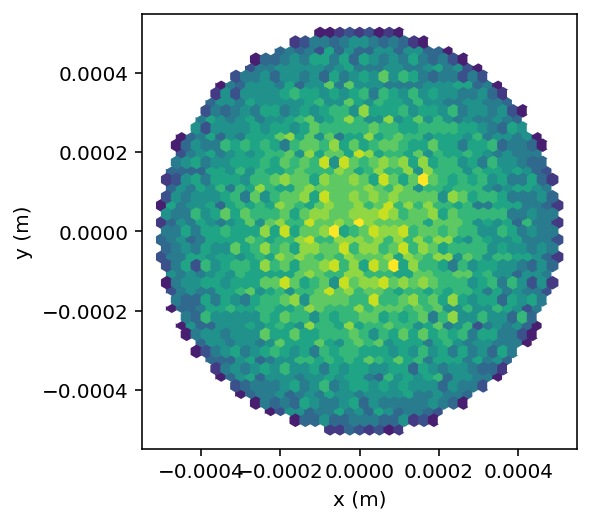

In [26]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
xkey = 'x'
ykey = 'y'
datx = P[xkey]
daty = P[ykey]
ax.set_xlabel(f'{xkey} ({P.units(xkey)})')
ax.set_ylabel(f'{ykey} ({P.units(ykey)})')
ax.hexbin(datx, daty, gridsize=40, cmap=cmap, vmin=1e-15)

In [27]:
# Cleanup
os.remove('astra.dat')
os.remove(newh5file)